In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots

In [2]:
param = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
structure = 'butane.psf'
scan = 'butane_scan_b3lyp_4.log'

In [3]:
butane_scan = ScanSet.parse_psi4(scan, structure)
butane_scan.compute_energy(param)

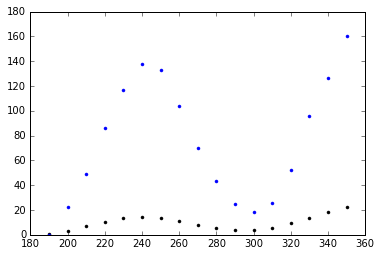

In [4]:
plt.plot(butane_scan.steps, butane_scan.qm_energy, 'k.')
plt.plot(butane_scan.steps, butane_scan.mm_energy, '.')

In [5]:
platform = mm.Platform.getPlatformByName('Reference')

In [6]:
model = Model.TorsionFitModelEliminatePhase(param, butane_scan, platform=platform, decouple_n=True, 
                                            param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')])

In [7]:
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_decouple_n.database', verbose=5)

In [8]:
sampler.sample(100000)

Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method Metropolis to stochastic log_sigma
 [-----------------100%-----------------] 100000 of 100000 complete in 3060.9 sec

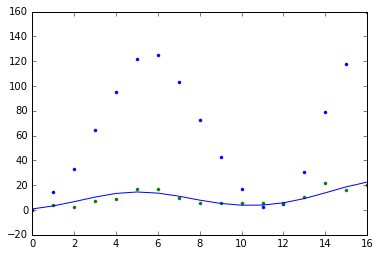

In [9]:
plt.plot(sampler.trace('mm_energy')[0], 'b.')
plt.plot(butane_scan.mm_energy, 'g.')
plt.plot(butane_scan.qm_energy)

(array([  3.98000000e+02,   1.18180000e+04,   6.52480000e+04,
          2.15160000e+04,   9.36000000e+02,   5.40000000e+01,
          1.00000000e+01,   2.00000000e+00,   0.00000000e+00,
          1.80000000e+01]),
 array([-5.715008 , -5.1435072, -4.5720064, -4.0005056, -3.4290048,
        -2.857504 , -2.2860032, -1.7145024, -1.1430016, -0.5715008,  0.       ]),
 <a list of 10 Patch objects>)

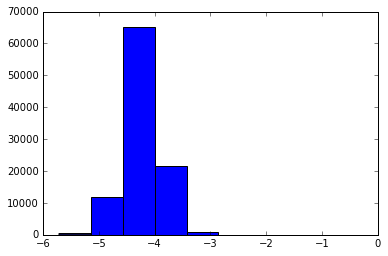

In [10]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[:])

(array([  4.40000000e+01,   3.46000000e+02,   3.34300000e+03,
          1.92980000e+04,   4.46700000e+04,   2.63470000e+04,
          5.23700000e+03,   6.47000000e+02,   5.50000000e+01,
          1.30000000e+01]),
 array([-1.679102 , -1.3166702, -0.9542384, -0.5918066, -0.2293748,
         0.133057 ,  0.4954888,  0.8579206,  1.2203524,  1.5827842,
         1.945216 ]),
 <a list of 10 Patch objects>)

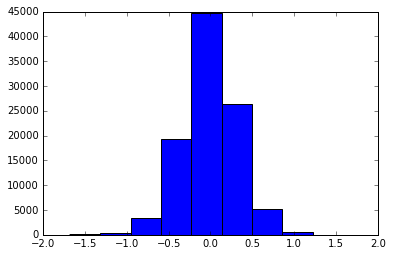

In [11]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[:])

(array([  4.69150000e+04,   5.30510000e+04,   8.00000000e+00,
          1.00000000e+00,   1.20000000e+01,   1.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          5.00000000e+00]),
 array([-16.393792 , -14.7544128, -13.1150336, -11.4756544,  -9.8362752,
         -8.196896 ,  -6.5575168,  -4.9181376,  -3.2787584,  -1.6393792,
          0.       ]),
 <a list of 10 Patch objects>)

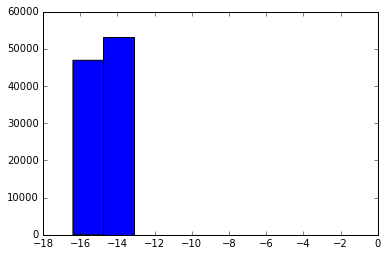

In [12]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[:])

(array([  1.65000000e+02,   3.67400000e+03,   4.66560000e+04,
          4.58050000e+04,   3.58100000e+03,   8.70000000e+01,
          1.20000000e+01,   0.00000000e+00,   5.00000000e+00,
          1.50000000e+01]),
 array([-2.379916 , -1.7925251, -1.2051342, -0.6177433, -0.0303524,
         0.5570385,  1.1444294,  1.7318203,  2.3192112,  2.9066021,
         3.493993 ]),
 <a list of 10 Patch objects>)

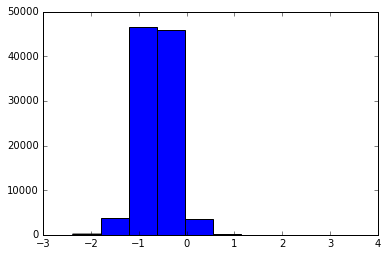

In [13]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[:])

(array([  7.00000000e+00,   5.20000000e+01,   2.75000000e+02,
          3.79600000e+03,   2.74130000e+04,   4.86510000e+04,
          1.76910000e+04,   2.00500000e+03,   8.70000000e+01,
          2.30000000e+01]),
 array([-3.012794 , -2.5987312, -2.1846684, -1.7706056, -1.3565428,
        -0.94248  , -0.5284172, -0.1143544,  0.2997084,  0.7137712,
         1.127834 ]),
 <a list of 10 Patch objects>)

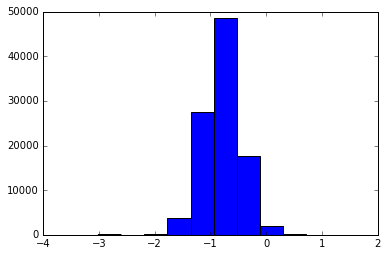

In [14]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[:])